**RUNNING dendroSEer FOR LARGE NUMBERS OF FIELDS**

This code is an example of how the dendroSEer method can be used to extract catalogs from large sets of images. I'll insert some comments to help you understand the steps, but feel free to reach out to me if you need any more clarification! 

In [8]:
#import CMZoom_utility as cmz
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
import astrodendro
import os
from astropy import wcs
from astrodendro import Dendrogram, pp_catalog
from astrodendro.analysis import PPStatistic
from astropy.table import Table, hstack, Column
from astropy.utils.console import ProgressBar
import reproject
import pandas as pd
import h5py
from astropy.io import ascii as aascii
from astropy.convolution import convolve_fft, Gaussian2DKernel

print(np.__version__)
%matplotlib inline
%config Completer.use_jedi = False


1.20.2


From ALMAGAL, we had two types of initial tests: fields with low level emission and injected fake sources and busy fields (lots of real emission) with injected sources. Both sources were just added as a post-processing step. Below is code that is used to construct and analyze these fields as if they were real data.

First, the flat fields:

In [9]:
####################################################################

### set up paths (you'll need to change these to your directory structure)
directory = '/Users/hph/Dropbox/astrophys/almagal_dendrogram/simdata_8_21/4_sources_simul_flat_pb0.5/'
savepath = '/Users/hph/Dropbox/astrophys/almagal_dendrogram/simdata_8_21/catalogs/'

### these are the identifiers for the flat regions:
regnames = ['118969',
            '105009',
            '103708',
            '100662']


In [10]:
### total arrays to store the information
### let me explain my naming scheme... 

### t is for "total", as in these are the arrays for the total collection (iffy choice on my part)

### 6 or 9 represents the flux level of injected sources
###   (I don't think this number actually corresponds to anything, just lower or higher)

### fluxerr will store the relative error for the flux of each extracted source
### this is defined as (F_d - F_0) / F_d (F_d is dendrogram flux, F_0 is true flux)
t_6_fluxerr = np.empty(0)

### n is the total number of sources recovered
t_6_n = np.empty(0)

### bgfluxerr is the background subtracted version of fluxerr
t_6_bgfluxerr = np.empty(0)

### regname is just the specific region identifier (this might not be necessary but was convenient for me)
t_6_regname = np.empty(0)

### this represents the specific source ID for each of the injected sources 
t_6_sourceID = np.empty(0)

### the x position of each source
t_6_x = np.empty(0)

### the y position of each source
t_6_y = np.empty(0)

### the 
t_6_dr = np.empty(0)

### the extracted dendrogram flux for each source
t_6_dendroflux = np.empty(0)

### the extracted background flux for each source
t_6_bgflux = np.empty(0)

### the real flux for each source (from the table)
t_6_trueflux = np.empty(0)

### the error in the effective size (FWHM vs dendrogram leaf size)
t_6_dfwhm = np.empty(0)

### then we define all the same storage arrays for the other field (there's probably a better way to do this)
t_9_fluxerr = np.empty(0)
t_9_n = np.empty(0)
t_9_bgfluxerr = np.empty(0)
t_9_regname = np.empty(0)
t_9_sourceID = np.empty(0)
t_9_x = np.empty(0)
t_9_y = np.empty(0)
t_9_dr = np.empty(0)
t_9_dendroflux = np.empty(0)
t_9_bgflux = np.empty(0)
t_9_trueflux = np.empty(0)
t_9_dfwhm = np.empty(0)

### define dendrogram parameters
dend_min_v = 3.0
dend_min_d = 0.1
dend_min_pix = 15

### first, we loop through the regions
for ri, regname in enumerate(regnames):
    ### then, we loop through the flux levels for each regions (a bit silly for 2, but you can scale it up)
    for fi, fluxlevel in enumerate(['9.00000','6.00000']):
        ### read in the source only image and load data into an array
        sources = fits.open(directory+regname+'_cont_7MTM2_jointdeconv.image_'+fluxlevel+'_sources.fits')
        sdata = sources[0].data[:,:]

        ### read the table of injected sources
        sfile = pd.read_csv(directory+regname+'_cont_7MTM2_jointdeconv.image_sourcepar_'+fluxlevel+'.dat',
                           header=6,delim_whitespace=True)
        sfile = sfile.drop([0,1]).astype(float)

        ### read in the simulated image and load data into array
        almasim = fits.open(directory+regname+'_cont_7MTM2_jointdeconv.image_'+fluxlevel+'_simul.fits')
        data = almasim[0].data[:,:]
        HeaderMod = almasim[0].header
        ### grab the WCS too!
        mywcs = wcs.WCS(HeaderMod)

        ### Process residuals into a noise map by convolving with Gaussian Kernel (size relative to beam)
        residfile = fits.open(directory+regname+'_cont_7MTM2_jointdeconv.residual.fits')
        imagelength = residfile[0].data[:][:].size
        resid = residfile[0].data[:][:]
        resid_mask = resid
        print("starting first fft...")
        smresid = convolve_fft(np.nan_to_num(resid), Gaussian2DKernel(15), psf_pad=False, fft_pad=False, allow_huge=True)
        noise_object = (resid-smresid)**2
        print("starting second fft...")
        noise_sqr = convolve_fft(noise_object,  Gaussian2DKernel(15), psf_pad=False, fft_pad=False, allow_huge=True)
        print("fft complete!")
        noisemap =noise_sqr**0.5
        noisemap[~np.isfinite(resid)] = np.nan

        ### specify dendrogram parameters for flat image
        ### first, define our noise level (in this case, from the kind of unrealistic residuals)
        noise=np.nanmean(np.abs(resid))
        ### run dendroSEer
        print( "Running dendrogram...")
        dend = astrodendro.Dendrogram.compute(data, min_value=float(dend_min_v)*noise, min_delta=float(dend_min_d)*noise,
                                              min_npix=dend_min_pix,
                                              wcs=mywcs)

        PixelAreaArcsec = 3600. * abs(HeaderMod['CDELT1']) * 3600. * abs(HeaderMod['CDELT2'])
        Metadata = {}
        Metadata['data_unit'] = u.Jy/u.beam
        Metadata['spatial_scale'] =  PixelAreaArcsec**0.5 * u.arcsec
        Metadata['beam_major'] = HeaderMod['BMAJ']*u.deg
        Metadata['beam_minor'] = HeaderMod['BMIN']*u.deg
        beam_omega_deg2 = HeaderMod['BMAJ']*HeaderMod['BMIN']*np.pi/(4*np.log(2))
        pix_area_deg2 = abs(HeaderMod['CDELT1']) * abs(HeaderMod['CDELT2'])
        pix_per_beam = beam_omega_deg2/pix_area_deg2
        as_per_pix = (np.abs(HeaderMod['CDELT1'])*3600)

        catalog = astrodendro.pp_catalog(dend, Metadata)
        catalog.rename_column('_idx', 'index')
        catalog.rename_column('flux', 'flux_integrated')

        keys = ['is_leaf', 'peak_cont_flux', 'min_cont_flux', 'mean_cont_flux','npix','mask']
        columns = {k:[] for k in (keys)}
        for ii, row in enumerate(ProgressBar(catalog)):
            structure = dend[row['index']]
            assert structure.idx == row['index'] == ii
            dend_inds = structure.indices()
            columns['is_leaf'].append(structure.is_leaf)
            peakflux = data[dend_inds].max()
            minflux = data[dend_inds].min()
            numpix = np.shape(dend_inds)[1]
            columns['peak_cont_flux'].append(peakflux)
            columns['min_cont_flux'].append(data[dend_inds].min())
            columns['mean_cont_flux'].append(data[dend_inds].mean())
            columns['npix'].append(numpix)
            columns['mask'].append(0)

        for k in columns:
                if k not in catalog.keys():
                    catalog.add_column(Column(name=k, data=columns[k]))

        cat_mask = (catalog['is_leaf'])
        leafcat = catalog[cat_mask]
        leafmask = dend.index_map.copy()

        for ii in ProgressBar(list(range(len(catalog)))):
            if ii not in leafcat['index']:
                leafmask[leafmask == ii] = -1
        
        ### from the source file for the true sources, load in the x and y coordinates for each source. 
        sxs, sys = np.array(sfile['|X'],dtype=int), np.array(sfile['|Y'],dtype=int)
        ### likewise load in the FWHM
        sxfwhms, syfwhms = np.array(sfile['|FWHM_X'],dtype=float), np.array(sfile['|FWHM_Y'],dtype=float)
        ### identify which, if any mask number from the catalog corresponds to those coordinates
        true_maski = leafmask[sys,sxs]
        ### set up some temporary storage arays
        dendro_flux=np.empty(0)
        true_flux=np.empty(0)
        fluxerr=np.empty(0)
        fluxerr_bgsub=np.empty(0)
        bg_flux=np.empty(0)

        ### now we loop through all the real sources 
        for i, index in enumerate(true_maski):
            ### we only care if the mask number is nonzero (meaning there's a leaf there)
            if true_maski[i]>=0:
                ### handle the cases for different fluxes separately (there's probably a better way to do this...)
                if fluxlevel=='6.00000':
                    t_6_regname = np.append(t_6_regname,regname)
                    t_6_sourceID = np.append(t_6_sourceID,i+1)
                    t_6_x = np.append(t_6_x,sxs[i])
                    t_6_y = np.append(t_6_y,sys[i])
                    ### get a mean FWHM from the real source
                    true_fwhm = (sxfwhms[i]+syfwhms[i])/2.
                    ### get an "effective" FWHM from the dendrogram leaf
                    dendro_fwhm = 2*np.sqrt(2*np.log(2))*((leafcat['major_sigma'][leafcat['index']==index]+leafcat['minor_sigma'][leafcat['index']==index])/2.)
                    ### calculate your error and store it
                    t_6_dfwhm = np.append(t_6_dfwhm, (true_fwhm - dendro_fwhm)/true_fwhm)
                    ### also record the positional centroid error! 
                    t_6_dr = np.append(t_6_dr,np.sqrt((leafcat['x_cen'][leafcat['index']==index]-sxs[i])**2 + (leafcat['y_cen'][leafcat['index']==index]-sys[i])**2))
                if fluxlevel=='9.00000':
                    t_9_regname = np.append(t_9_regname,regname)
                    t_9_sourceID = np.append(t_9_sourceID,i+1)
                    t_9_x = np.append(t_9_x,sxs[i])
                    t_9_y = np.append(t_9_y,sys[i])
                    true_fwhm = (sxfwhms[i]+syfwhms[i])/2.
                    dendro_fwhm = 2*np.sqrt(2*np.log(2))*((leafcat['major_sigma'][leafcat['index']==index]+leafcat['minor_sigma'][leafcat['index']==index])/2.)
                    t_9_dfwhm = np.append(t_9_dfwhm, (true_fwhm - dendro_fwhm)/true_fwhm)
                    t_9_dr = np.append(t_9_dr,np.sqrt((leafcat['x_cen'][leafcat['index']==index]-sxs[i])**2 + (leafcat['y_cen'][leafcat['index']==index]-sys[i])**2))
                ### Now, look to the fluxes for each and calculate errors
                ### First, the background flux. We use an empirical factor of 0.3 here because our
                ### background estimation is overly simple and the simulation method makes it difficult to
                ### appropriately etimate the background from the residuals
                bg_flux = np.append(bg_flux,0.3*np.min(data[np.where(leafmask==index)])*leafcat['npix'][np.where(leafcat['index']==index)].data/pix_per_beam)
                ### important note, we ammend the dendrogram flux with a factor of 1.8 representing the difference
                ### between the dendrogram leaf, which we assume represents the FWHM contour (very rough assumption)
                ### and so we need a geometrical factor to compare it to a gaussian integrated to infinity (like in the table)
                dendro_flux = np.append(dendro_flux,1.8*leafcat['flux_integrated'][leafcat['index']==index])
                true_flux = np.append(true_flux,sfile['|F_int'].iloc[i])
                fluxerr = np.append(fluxerr,(dendro_flux[-1]-true_flux[-1])/dendro_flux[-1])
                fluxerr_bgsub = np.append(fluxerr_bgsub,((dendro_flux[-1]-bg_flux[-1])-true_flux[-1])/(dendro_flux[-1]-bg_flux[-1]))
        ### append these arrays to the total arrays
        if fluxlevel=='9.00000':
            t_9_dendroflux=np.append(t_9_dendroflux,dendro_flux)
            t_9_bgflux=np.append(t_9_bgflux,bg_flux)
            t_9_trueflux=np.append(t_9_trueflux,true_flux)
            t_9_bgfluxerr=np.append(t_9_bgfluxerr,fluxerr_bgsub)
            t_9_fluxerr=np.append(t_9_fluxerr,fluxerr)
            t_9_n=np.append(t_9_n,np.sum(true_maski>=0))
        if fluxlevel=='6.00000':
            t_6_dendroflux=np.append(t_6_dendroflux,dendro_flux)
            t_6_bgflux=np.append(t_6_bgflux,bg_flux)
            t_6_trueflux=np.append(t_6_trueflux,true_flux)
            t_6_bgfluxerr=np.append(t_6_bgfluxerr,fluxerr_bgsub)
            t_6_fluxerr=np.append(t_6_fluxerr,fluxerr)
            t_6_n=np.append(t_6_n,np.sum(true_maski>=0))


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


starting first fft...
starting second fft...
fft complete!
Running dendrogram...
Computing catalog for 22 structures

[=>                                       ] 4%
[===>                                     ] 9%
[=====>                                   ] 13%
[=======>                                 ] 18%
[=========>                               ] 22%
[==========>                              ] 27%
[============>                            ] 31%
[==============>                          ] 36%
[================>                        ] 40%
[==================>                      ] 45%
[====================>                    ] 50%
[=====================>                   ] 54%
[=======================>                 ] 59%
[=========================>               ] 63%
[===========================>             ] 68%
[=============================>           ] 72%
[==============================>          ] 77%
[================================>        ] 81%
[===================

starting first fft...
starting second fft...


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


fft complete!
Running dendrogram...
Computing catalog for 22 structures

[=>                                       ] 4%
[===>                                     ] 9%
[=====>                                   ] 13%
[=======>                                 ] 18%
[=========>                               ] 22%
[==========>                              ] 27%
[============>                            ] 31%
[==============>                          ] 36%
[================>                        ] 40%
[==================>                      ] 45%
[====================>                    ] 50%
[=====================>                   ] 54%
[=======================>                 ] 59%
[=========================>               ] 63%
[===========================>             ] 68%
[=============================>           ] 72%
[==============================>          ] 77%
[================================>        ] 81%
[==================================>      ] 86%
[================


[========================================>] 100%
starting first fft...
starting second fft...


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


fft complete!
Running dendrogram...
Computing catalog for 27 structures

[=>                                       ] 3%
[==>                                      ] 7%
[====>                                    ] 11%
[=====>                                   ] 14%
[=======>                                 ] 18%
[========>                                ] 22%
[==========>                              ] 25%
[===========>                             ] 29%
[=============>                           ] 33%
[==============>                          ] 37%
[================>                        ] 40%
[=================>                       ] 44%
[===================>                     ] 48%
[====================>                    ] 51%
[======================>                  ] 55%
[=======================>                 ] 59%
[=========================>               ] 62%
[==========================>              ] 66%
[============================>            ] 70%
[================

starting first fft...
starting second fft...


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


fft complete!
Running dendrogram...
Computing catalog for 27 structures

[=>                                       ] 3%
[==>                                      ] 7%
[====>                                    ] 11%
[=====>                                   ] 14%
[=======>                                 ] 18%
[========>                                ] 22%
[==========>                              ] 25%
[===========>                             ] 29%
[=============>                           ] 33%
[==============>                          ] 37%
[================>                        ] 40%
[=================>                       ] 44%
[===================>                     ] 48%
[====================>                    ] 51%
[======================>                  ] 55%
[=======================>                 ] 59%
[=========================>               ] 62%
[==========================>              ] 66%
[============================>            ] 70%
[================

starting first fft...
starting second fft...


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


fft complete!
Running dendrogram...
Computing catalog for 25 structures

[=>                                       ] 4%
[===>                                     ] 8%
[====>                                    ] 12%
[======>                                  ] 16%
[========>                                ] 20%
[=========>                               ] 24%
[===========>                             ] 28%
[============>                            ] 32%
[==============>                          ] 36%
[================>                        ] 40%
[=================>                       ] 44%
[===================>                     ] 48%
[====================>                    ] 52%
[======================>                  ] 56%
[========================>                ] 60%
[=========================>               ] 64%
[===========================>             ] 68%
[============================>            ] 72%
[==============================>          ] 76%
[================

starting first fft...
starting second fft...
fft complete!


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Running dendrogram...
Computing catalog for 26 structures

[=>                                       ] 3%
[===>                                     ] 7%
[====>                                    ] 11%
[======>                                  ] 15%
[=======>                                 ] 19%
[=========>                               ] 23%
[==========>                              ] 26%
[============>                            ] 30%
[=============>                           ] 34%
[===============>                         ] 38%
[================>                        ] 42%
[==================>                      ] 46%
[====================>                    ] 50%
[=====================>                   ] 53%
[=======================>                 ] 57%
[========================>                ] 61%
[==========================>              ] 65%
[===========================>             ] 69%
[=============================>           ] 73%
[==============================

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


starting first fft...
starting second fft...
fft complete!
Running dendrogram...
Computing catalog for 14 structures

[==>                                      ] 7%
[=====>                                   ] 14%
[========>                                ] 21%
[===========>                             ] 28%
[==============>                          ] 35%
[=================>                       ] 42%
[====================>                    ] 50%
[======================>                  ] 57%
[=========================>               ] 64%
[============================>            ] 71%
[===============================>         ] 78%


[==================================>      ] 85%
[=====================================>   ] 92%
[=======================================> ] 99%
[========================================>] 100%
starting first fft...
starting second fft...
fft complete!
Running dendrogram...
Computing catalog for 13 structures

[===>                                     ] 7%
[======>                                  ] 15%
[=========>                               ] 23%
[============>                            ] 30%
[===============>                         ] 38%
[==================>                      ] 46%
[=====================>                   ] 53%
[========================>                ] 61%
[===========================>             ] 69%
[==============================>          ] 76%
[=================================>       ] 84%
[====================================>    ] 92%
[========================================>] 100%
[========================================>] 100%

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [ ]:
### The save catalog as ascii file
### if you change parameters, you ought to change the file names to match!! Or come up with your own naming convention
###
fcomment = 'column descriptions: \n reg_name: region ID. \n source_index: source ID from table. \n X center from the table. \n Y center from the table. \n dendro_flux: flux measured by astrodendro (F). \n bg_flux: background flux used for subtraction. \n true_flux: flux listed in the source table (F_0). \n flux_err: flux discrepency, (F_0-F) / F_0 \n flux_err_bgsub: background subtracted flux discrepency, (F_0-F_bgs) / F_0'
aascii.write([np.array(t_9_regname),np.array(t_9_sourceID),np.array(t_9_x), np.array(t_9_y), np.array(t_9_dendroflux), np.array(t_9_bgflux), np.array(t_9_trueflux), np.array(t_9_fluxerr), np.array(t_9_bgfluxerr)], 
             savepath+'sourcecatalog_flat_f9.00000_ndm_v3_d1.5_p15.dat', 
             names=['reg_name','source_index','X', 'Y', 'dendro_flux','bg_flux','true_flux','flux_err','flux_err_bgsub'], overwrite=True,
             comment = fcomment)
aascii.write([np.array(t_6_regname),np.array(t_6_sourceID),np.array(t_6_x), np.array(t_6_y), np.array(t_6_dendroflux), np.array(t_6_bgflux), np.array(t_6_trueflux), np.array(t_6_fluxerr), np.array(t_6_bgfluxerr)], 
             savepath+'sourcecatalog_flat_f6.00000_ndm_v3_d1.5_p15.dat', 
             names=['reg_name','source_index','X', 'Y', 'dendro_flux','bg_flux','true_flux','flux_err','flux_err_bgsub'], overwrite=True,
             comment = fcomment)

In [ ]:
### now we plot! 

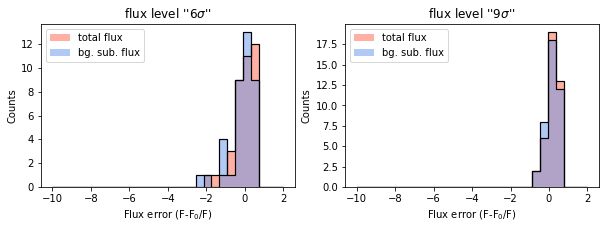

In [11]:
### first, let's plot the flux errors:
plt.close()
fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(10,3))
ax=axes[0]
ax.hist(t_6_fluxerr,bins=np.linspace(-10,2,30),alpha=0.5,color='tomato',label='total flux')
ax.hist(t_6_fluxerr,bins=np.linspace(-10,2,30),alpha=1.0,color='k',histtype='step',lw=1.2)
ax.hist(t_6_bgfluxerr,bins=np.linspace(-10,2,30),alpha=0.5,color='cornflowerblue',label='bg. sub. flux')
ax.hist(t_6_bgfluxerr,bins=np.linspace(-10,2,30),alpha=1.0,color='k',histtype='step',lw=1.2)
ax.set_title('flux level \'\'6$\sigma$\'\'')
ax.set_xlabel('Flux error (F-F$_0$/F)')
ax.set_ylabel('Counts')
ax.legend()

ax=axes[1]
ax.hist(t_9_fluxerr,bins=np.linspace(-10,2,30),alpha=0.5,color='tomato',label='total flux')
ax.hist(t_9_fluxerr,bins=np.linspace(-10,2,30),alpha=1.0,color='k',histtype='step',lw=1.2)
ax.hist(t_9_bgfluxerr,bins=np.linspace(-10,2,30),alpha=0.5,color='cornflowerblue',label='bg. sub. flux')
ax.hist(t_9_bgfluxerr,bins=np.linspace(-10,2,30),alpha=1.0,color='k',histtype='step',lw=1.2)
ax.set_xlabel('Flux error (F-F$_0$/F)')
ax.set_ylabel('Counts')
ax.set_title('flux level \'\'9$\sigma$\'\'')
ax.legend()

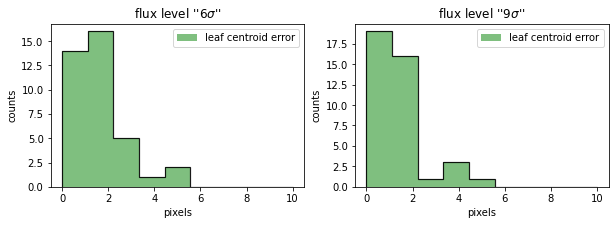

In [12]:
### Plot positional error in the centroids:
plt.close()
fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(10,3))
ax=axes[0]
ax.hist(t_6_dr,bins=np.linspace(0,10,10),alpha=0.5,color='green',label='leaf centroid error')
ax.hist(t_6_dr,bins=np.linspace(0,10,10),alpha=0.9,color='k',histtype='step',lw=1.2)
ax.set_title('flux level \'\'6$\sigma$\'\'')
ax.set_xlabel('pixels')
ax.set_ylabel('counts')
ax.legend()

ax=axes[1]
ax.hist(t_9_dr,bins=np.linspace(0,10,10),alpha=0.5,color='green',label='leaf centroid error')
ax.hist(t_9_dr,bins=np.linspace(0,10,10),alpha=0.9,color='k',histtype='step',lw=1.2)
ax.set_title('flux level \'\'9$\sigma$\'\'')
ax.set_xlabel('pixels')
ax.set_ylabel('counts')
ax.legend()

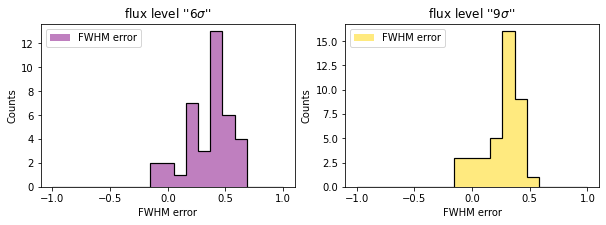

In [14]:
### Next, plot the FWHM error
plt.close()
fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(10,3))
ax=axes[0]
#ax.hist(t_6_fluxerr,bins=np.linspace(-2,1,20),alpha=0.5,color='tomato',label='total flux')
ax.hist(t_6_dfwhm,bins=np.linspace(-1,1,20),alpha=0.5,color='purple',label='FWHM error')
ax.hist(t_6_dfwhm,bins=np.linspace(-1,1,20),alpha=1.0,color='k',histtype='step',lw=1.2)
ax.set_title('flux level \'\'6$\sigma$\'\'')
ax.set_xlabel('FWHM error')
ax.set_ylabel('Counts')
ax.legend()

ax=axes[1]
#ax.hist(t_9_fluxerr,bins=np.linspace(-2,1,20),alpha=0.5,color='tomato',label='total flux')
ax.hist(t_9_dfwhm,bins=np.linspace(-1,1,20),alpha=0.5,color='gold',label='FWHM error')
ax.hist(t_9_dfwhm,bins=np.linspace(-1,1,20),alpha=1.0,color='k',histtype='step',lw=1.2)
ax.set_xlabel('FWHM error')
ax.set_ylabel('Counts')
ax.set_title('flux level \'\'9$\sigma$\'\'')
ax.legend()

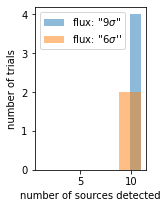

In [13]:
### finally, plot the rate of recovery (number sources detected out of 10 injected sources)
plt.close()
fig,ax=plt.subplots(figsize=(2,3))
ax.hist(t_9_n,bins=np.linspace(1,11,10),alpha=0.5,label='flux: \'\'9$\sigma$\'\'')
ax.hist(t_6_n,bins=np.linspace(1,11,10),alpha=0.5,label='flux: \'\'6$\sigma$\'\'')
ax.set_xlabel('number of sources detected')
ax.set_ylabel('number of trials')
ax.legend()